<a href="https://colab.research.google.com/github/aayushkubb/nlp/blob/main/QUORA_Class_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK for next week

Students need to improve the f1-score. This can be done by trying to

Lemmatize
Stemming

Hashing Vectors
Vount Vectors

Standardisation

etc..

# Mount the drive

Please make sure the below folder is added to your drive

https://drive.google.com/drive/folders/1wcwKLy8SFu4iugPhzJNovpwvzyIQPP_D?usp=sharing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Problem Definition
---
I think one of the important things when you start a new machine learning project is Defining your problem. that means you should understand business problem.( Problem Formalization)

> We will be predicting whether a question asked on Quora is sincere or not

Data Source : https://www.kaggle.com/c/quora-insincere-questions-classification/data

**About Quora**

Quora is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.

**Business View**

An existential problem for any major website today is how to handle toxic and divisive content. Quora wants to tackle this problem head-on to keep their platform a place where users can feel safe sharing their knowledge with the world.

**What is a insincere question?**

Is defined as a question intended to make a statement rather than look for helpful answers.

<img src="https://drive.google.com/uc?id=1XOvVoEDjNF_p2tHV1H9XzoZHxfzBBA5t"/>

**Feature Set**

We use train.csv and test.csv as Input and we should upload a submission.csv as Output.

The training set contains the following 3 features (for Supervised Learning)
1. qid - unique question identifier
2. question_text - Quora question text
3. target - a question labeled "insincere" has a value of 1, otherwise 0

In [2]:
!pip install nltk


# Import Statements

In [143]:
import pandas as pd
import numpy as np
import nltk
import re


from nltk.util import ngrams
from collections import Counter
from nltk.corpus import stopwords

#Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.metrics import classification_report
# nltk.download('all')

# Read the datasets

In [91]:
train=pd.read_csv('/content/drive/MyDrive/Quora/QuoratrainSet.csv')
test=pd.read_csv('/content/drive/MyDrive/Quora/Quoratestdata.csv')

In [92]:
train.shape, test.shape

((1048575, 3), (375806, 2))

In [93]:
#Just for the class we will sample
train=train.sample(frac=.01)
test=test.sample(frac=.01)

In [94]:
train.head()

qid  ... target
218787  2acca501f5e0e623984a  ...      0
385172  4b74856dbb6440ca161f  ...      0
384097  4b42d55656fb3dc1e7bd  ...      0
197093  26885b2aff395a4b7b3d  ...      0
873728  ab2e0c85825ffb0f61ce  ...      0

[5 rows x 3 columns]

In [95]:
test.head()

qid                                      question_text
363681  f7dcd18dde867df3ce8b  How many electrons will flow, if the (current ...
160148  6cff4b50f00745c97482  How can I take advantage of my appearance wisely?
57774   27569a217de574015257  Where can I browse and get an online job in Au...
17789   0c0d2afef5135a414646  Do Lyft and Uber drivers actually make money a...
187490  7f8d8cf8dfe3418c85ff               How much time it requires to update?

In [96]:
train['target'].value_counts(normalize=True)

0    0.936677
1    0.063323
Name: target, dtype: float64

# Approach



1.   Try to understand the data a bit.
    *   Patterns - NGRAMs
    *   EDA - WORDCLOUD

2. Success Criteria - F1 score  
3. Baseline Approach
4. Clean the data
      *   Lowercase
      *   Tokeniser
      *   Remove Stopwords
      *   Remove non-apha text
      *   Lemmatisation/Stemming

5. Prepare the data for training
      *   Word to numeric features - Count and TFIDF 
      *   Standardize these features

6. Build our model
7. Evaluate and Repeat of required






In [97]:
def ngram_finder(tokens):
  bigrams = nltk.collocations.BigramAssocMeasures()
  bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)

  #bigrams
  bigram_freq = bigramFinder.ngram_fd.items()
  bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)
  


  trigrams = nltk.collocations.TrigramAssocMeasures()
  trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)

  #trigrams
  trigram_freq = trigramFinder.ngram_fd.items()
  trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)
  

  return bigramFreqTable,trigramFreqTable


# Basic Data Cleaning

In [98]:
characters=[]
for i in train['question_text'].tolist():
  for j in i.split():
    for k in j:
      characters.append(k)

In [99]:
re.sub('[^a-z ]',"","hey this, is me 123 ?")

'hey this is me  '

In [117]:
#STopwords
Stopwords = set(stopwords.words('english'))
Stopwords.add("a")


def data_cleaner(row):

  '''Cleaner utility for text'''

  #lowercasing
  row=row.lower()
  # print(row)

  #Remove anything apart from alphabets
  row=re.sub('[^a-z ]',"",row)
  # print(row)

  #Strip
  row=row.strip()
  # print(row)

  #Lets remove stopwords
  row=" ".join([i for i in row.split() if i not in Stopwords])
  # print(row)
  return row





In [118]:
train['question_text']=train['question_text'].apply(data_cleaner)

In [119]:
train=train[train['question_text'].apply(lambda x: len(x.split())>=2)]

In [120]:
# Tokeniser
tokens=[]
for i in train.loc[train['target']==1,'question_text']:
  tokens.extend(nltk.word_tokenize(i.lower()))

for i in tokens:
  if i in Stopwords:
    tokens.remove(i)
bigramFreqTable,trigramFreqTable=ngram_finder(tokens)
bigramFreqTable

bigram  freq
317      (donald, trump)     7
1371     (black, people)     6
647    (prime, minister)     5
1080      (gun, control)     5
520      (white, people)     5
...                  ...   ...
1953          (go, away)     1
1952       (hillary, go)     1
1951     (wont, hillary)     1
1950    (religion, wont)     1
5736  (equality, dinner)     1

[5737 rows x 2 columns]

In [121]:
# Tokeniser
tokens=[]
for i in train.loc[train['target']==0,'question_text']:
  tokens.extend(nltk.word_tokenize(i.lower()))

for i in tokens:
  if i in Stopwords:
    tokens.remove(i)
bigramFreqTable,trigramFreqTable=ngram_finder(tokens)
bigramFreqTable

bigram  freq
1552             (best, way)    58
1359             (year, old)    33
1053         (would, happen)    31
300            (whats, best)    28
15          (united, states)    26
...                      ...   ...
19857  (respected, european)     1
19858    (european, nations)     1
19859          (nations, st)     1
19861    (century, favorite)     1
56944    (designing, lldhld)     1

[56945 rows x 2 columns]

In [122]:
train['length_sentence']=train['question_text'].apply(lambda x: len(x.split()))

In [123]:
train.groupby(by='target').describe()

length_sentence                                ... predictions_baseline                    
                 count      mean       std  min  25%  ...                  min  25%  50%  75%  max
target                                                ...                                         
0               9755.0  6.287852  3.492159  2.0  4.0  ...                  0.0  0.0  0.0  0.0  1.0
1                664.0  8.941265  5.045600  2.0  5.0  ...                  0.0  0.0  0.0  0.0  1.0

[2 rows x 16 columns]

# Baseline Model

In [126]:
train['predictions_baseline']=train['length_sentence'].apply(lambda x: 1 if x>13 else 0)

In [127]:
print(classification_report(train['target'],train['predictions_baseline']))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      9755
           1       0.20      0.17      0.18       664

    accuracy                           0.90     10419
   macro avg       0.57      0.56      0.56     10419
weighted avg       0.90      0.90      0.90     10419



In [128]:
#lets check on the test set
test['question_text']=test['question_text'].apply(data_cleaner)
test['length_sentence']=test['question_text'].apply(lambda x: len(x.split()))
test['predictions_baseline']=test['length_sentence'].apply(lambda x: 1 if x>13 else 0)
test.loc[test['predictions_baseline']==1,'question_text'].tolist()

# Visualisation

In [132]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

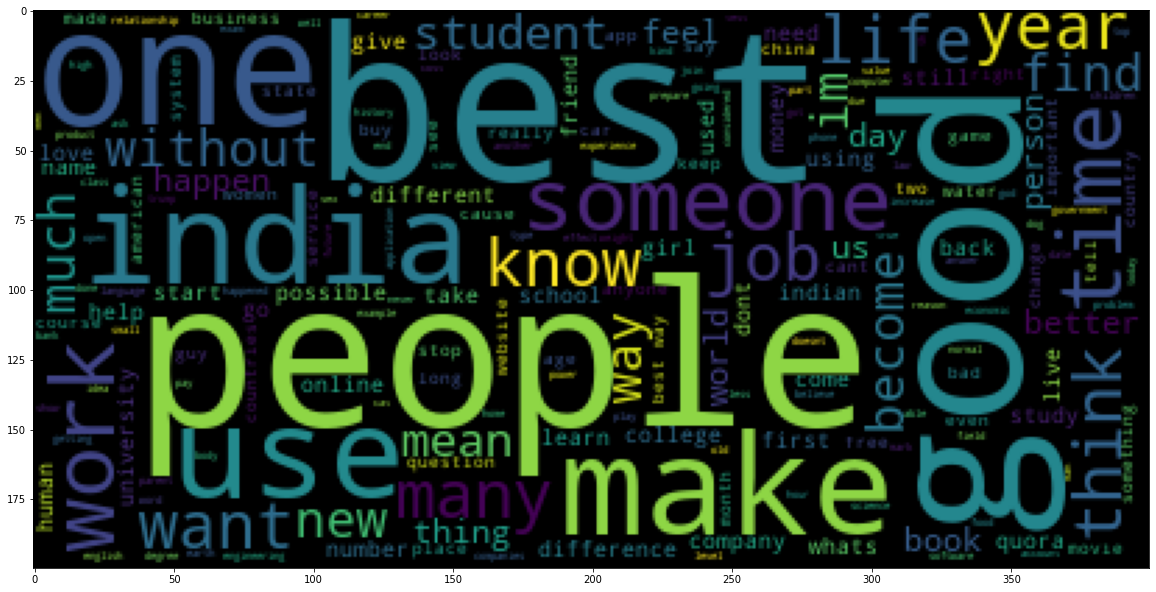

In [139]:
# Sincere
wc=WordCloud().generate(" ".join(train.loc[train['target']==0,'question_text'].tolist()))
fig = plt.figure(1, figsize = (20, 20))
plt.imshow(wc)
plt.show()

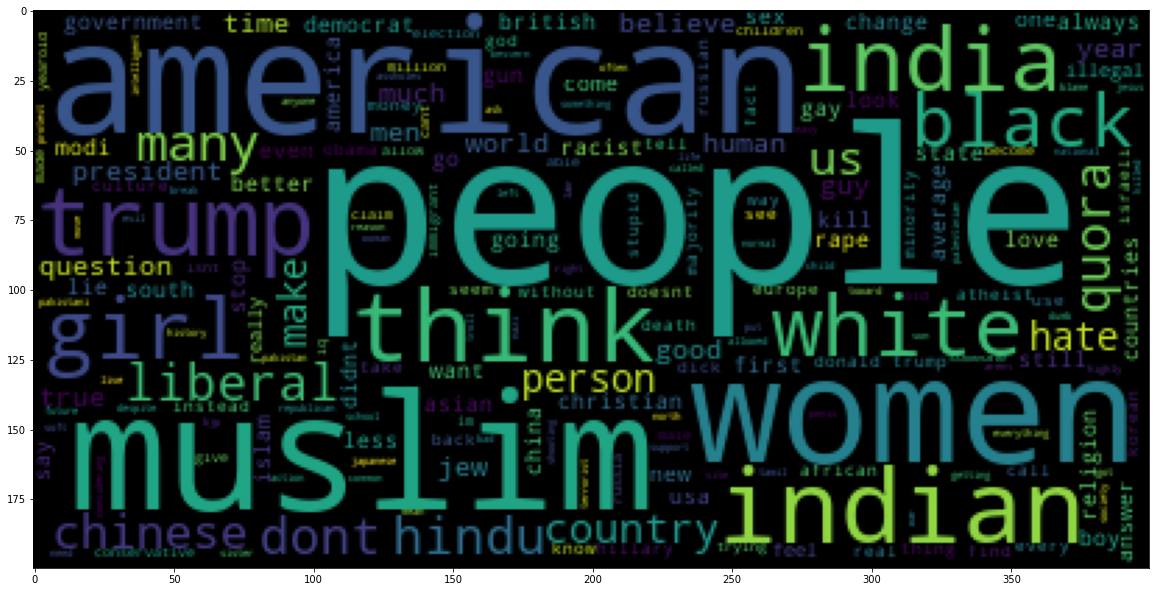

In [140]:
# InSincere
wc=WordCloud().generate(" ".join(train.loc[train['target']==1,'question_text'].tolist()))
fig = plt.figure(1, figsize = (20, 20))
plt.imshow(wc)
plt.show()

# Baseline Model- 2

In [141]:
def baseline_Classifier(text):
  if 'trump' in text or 'muslim' in text or 'black' in text or 'american' in text or 'indian' in text or 'gun' in text or 'sex' in text:
    return 1
  else:
    return 0

In [142]:
train['predictions_baseline2']=train['question_text'].apply(baseline_Classifier)
print(classification_report(train['target'],train['predictions_baseline2']))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      9755
           1       0.37      0.34      0.35       664

    accuracy                           0.92     10419
   macro avg       0.66      0.65      0.65     10419
weighted avg       0.92      0.92      0.92     10419



# Data prep

In [154]:
#Create the transform
vectorizer = TfidfVectorizer()

#Tokenize and build vocab
vectorizer.fit(train['question_text'])

#Summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)

{'people': 10222, 'store': 13288, 'number': 9597, 'phone': 10347, 'dont': 4104, 'talk': 13710, 'school': 12212, 'stop': 13282, 'using': 14703, 'selfdeprecation': 12348, 'defense': 3585, 'mechanism': 8628, 'opinion': 9781, 'politicians': 10560, 'united': 14580, 'states': 13194, 'start': 13178, 'learn': 7878, 'programming': 10916, 'ruby': 11990, 'rails': 11234, 'boyfriends': 1744, 'mother': 9053, 'straight': 13301, 'tells': 13826, 'eventually': 4756, 'cheat': 2348, 'believe': 1374, 'wait': 14999, 'see': 12316, 'happens': 6128, 'iphones': 7203, 'save': 12156, 'contacts': 2976, 'memory': 8685, 'current': 3355, 'job': 7409, 'scenario': 12192, 'trump': 14360, 'us': 14684, 'ms': 9096, 'mechanical': 8626, 'engineering': 4573, 'indian': 6863, 'work': 15322, 'ex': 4776, 'help': 6268, 'look': 8163, 'buy': 1967, 'jewelry': 7381, 'staring': 13173, 'normal': 9528, 'china': 2407, 'stay': 13209, 'family': 4999, 'deposit': 3685, 'home': 6409, 'light': 8021, 'wave': 15077, 'photon': 10362, 'heading': 62

In [155]:
sample_text=train['question_text'].tolist()[0]
print(sample_text)

people store number phone dont talk phone school


In [156]:
vectorizer.transform([sample_text]).toarray().shape

(1, 15533)

In [157]:
vectorizer.transform(["The fox"]).toarray().shape

(1, 15533)

In [158]:
from sklearn.model_selection import train_test_split

In [160]:
#Target and predictors
X=train['question_text']
y=train['target']

In [161]:
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.3,random_state=1)

In [163]:
X_train.shape,X_test.shape

((7293,), (3126,))

In [165]:
X_train_vectors=vectorizer.transform(X_train)
X_test_vectors=vectorizer.transform(X_test)

In [167]:
X_test_vectors.toarray().shape

(3126, 15533)

# Models

## Random Forest

In [169]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()



In [170]:
rf.fit(X_train_vectors,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [171]:
#Predictions
y_pred=rf.predict(X_test_vectors)

In [172]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2918
           1       0.73      0.08      0.14       208

    accuracy                           0.94      3126
   macro avg       0.83      0.54      0.55      3126
weighted avg       0.92      0.94      0.91      3126



## SVM

In [174]:
from sklearn import svm
SVM=svm.SVC(C=1.0,kernel='linear',degree=3,gamma='auto')
SVM.fit(X_train_vectors,y_train)
#Predictions
y_pred=SVM.predict(X_test_vectors)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2918
           1       0.68      0.12      0.20       208

    accuracy                           0.94      3126
   macro avg       0.81      0.56      0.59      3126
weighted avg       0.92      0.94      0.92      3126



In [176]:
y_pred_prob=rf.predict_proba(X_test_vectors)

In [181]:
y_pred_prob[10]

array([0.99, 0.01])

In [188]:
y_pred=[]
for i in y_pred_prob:
  if i[1] >0.1:
    y_pred.append(1)
  else:
    y_pred.append(0)


In [189]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.94      2918
           1       0.31      0.61      0.41       208

    accuracy                           0.88      3126
   macro avg       0.64      0.76      0.67      3126
weighted avg       0.93      0.88      0.90      3126

